In [1]:
!pip install contractions 

In [2]:
!pip install inflect
!pip install pandas-profiling==2.7.1

In [3]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#palabras vacías
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

In [7]:
data=pd.read_csv("SuicidiosProyecto.csv", sep=',', encoding = 'utf-8', index_col=0)

In [8]:
data

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,I kinda got behind schedule with learning for ...,non-suicide
256637,I'm just not sure anymoreFirst and foremost: I...,suicide
303772,please give me a reason to liveThats too much ...,suicide
293747,27f struggling to find meaning moving forwardI...,suicide
...,...,...
248038,Drop some cool new cereal ideas Like what woul...,non-suicide
216516,Unpopular opinion but cats deserve love and re...,non-suicide
199341,Hey guys :) How yall doin?,non-suicide


# Perfilamiento y entendimiento de los datos

In [9]:
from statistics import mode
#from pandas.core.dtypes.generic import ABCIndexClass

textos = data.copy()
textos['Conteo'] = [len(x) for x in textos['text']]
textos['Moda'] = [[mode([len(x) for x in i.split(' ')])][0] for i in textos['text']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['text']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['text']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)


# Preparación de los datos

In [10]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_words.append(new_word)
    return new_words
'''
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
'''

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))
    new_words = []
    for word in words:
        if word not in stop_words: 
            new_words.append(word)
        else:
            new_words.append(" ")
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [11]:
data_t = data.copy()
data_t['text'] = preprocessing(data_t['text'])

In [12]:
#tokenización 
#data_t = data.copy()
data_t['text'] = data_t['text'].apply(contractions.fix)

In [13]:
data_t

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,i kind of got behind schedule with learning fo...,non-suicide
256637,i am just not sure anymorefirst and foremost i...,suicide
303772,please give me a reason to livethats too much ...,suicide
293747,27f struggling to find meaning moving forwardi...,suicide
...,...,...
248038,drop some cool new cereal ideas like what woul...,non-suicide
216516,unpopular opinion but cats deserve love and re...,non-suicide
199341,hey guys how you all doin,non-suicide


In [14]:
data_t['words'] = data_t['text'].apply(word_tokenize)
data_t.head()


,text,class,words
Unnamed: 0,,,
173271,i want to destroy myselffor once everything wa...,suicide,"[i, want, to, destroy, myselffor, once, everyt..."
336321,i kind of got behind schedule with learning fo...,non-suicide,"[i, kind, of, got, behind, schedule, with, lea..."
256637,i am just not sure anymorefirst and foremost i...,suicide,"[i, am, just, not, sure, anymorefirst, and, fo..."
303772,please give me a reason to livethats too much ...,suicide,"[please, give, me, a, reason, to, livethats, t..."
293747,27f struggling to find meaning moving forwardi...,suicide,"[27f, struggling, to, find, meaning, moving, f..."


In [15]:
import nltk
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
def lemmatize_verbs(words):
    new_words =[]
    for word in words:
        a = str(lemmatizer.lemmatize(word,pos='v'))
        new_words.append(a)
    return new_words


In [17]:
for i in data_t.index:
    a=data_t["words"][i]
    lemmatize_verbs(a)

In [18]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [19]:
def stem_words(words):
    new_words =[]
    for word in words:
        a = str(porter.stem(word))
        new_words.append(a)
    return new_words

In [20]:
for i in data_t.index:
    b=data_t["words"][i]
    stem_words(b)

In [21]:
#Separar variable predictora y los textos a usar
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,text,class,words
Unnamed: 0,,,
173271,i want to destroy myselffor once everything wa...,suicide,i want to destroy myselffor once everything wa...
336321,i kind of got behind schedule with learning fo...,non-suicide,i kind of got behind schedule with learning fo...
256637,i am just not sure anymorefirst and foremost i...,suicide,i am just not sure anymorefirst and foremost i...
303772,please give me a reason to livethats too much ...,suicide,please give me a reason to livethats too much ...
293747,27f struggling to find meaning moving forwardi...,suicide,27f struggling to find meaning moving forwardi...
...,...,...,...
248038,drop some cool new cereal ideas like what woul...,non-suicide,drop some cool new cereal ideas like what woul...
216516,unpopular opinion but cats deserve love and re...,non-suicide,unpopular opinion but cats deserve love and re...
199341,hey guys how you all doin,non-suicide,hey guys how you all doin


In [22]:
X_data, y_data = data_t['words'],data_t['class']
y_data = (y_data == 'suicide').astype(int)

In [23]:
y_data

Unnamed: 0
173271    1
336321    0
256637    1
303772    1
293747    1
         ..
248038    0
216516    0
199341    0
145373    0
305170    1
Name: class, Length: 195700, dtype: int32

In [24]:
y_data.describe()

count    195700.000000
mean          0.437072
std           0.496026
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: class, dtype: float64

In [25]:
X_data_recorte = X_data.head(10000)

In [26]:
y_data_recorte = y_data.head(10000)

In [27]:
X_data_recorte

Unnamed: 0
173271    i want to destroy myselffor once everything wa...
336321    i kind of got behind schedule with learning fo...
256637    i am just not sure anymorefirst and foremost i...
303772    please give me a reason to livethats too much ...
293747    27f struggling to find meaning moving forwardi...
                                ...                        
259537    goodnight leave me a messege that ill be reply...
209248    white men and women are the least excluded in ...
194661    i am so sick of everythingim so sick of feelin...
257634    goodnight rteenagers its 1218 and i am going t...
108322    need someone to talk tothinking about killing ...
Name: words, Length: 10000, dtype: object

In [28]:
#Transformacion Term-Frequency
tf_idf = TfidfVectorizer()
x_tf_idf = tf_idf.fit_transform(X_data_recorte)
print(x_tf_idf.shape)

(10000, 31542)


In [29]:
df2 = pd.DataFrame(x_tf_idf.toarray().transpose(),
                   index=tf_idf.get_feature_names())
print(df2)

                  0     1     2     3     4     5     6     7     8     9     \
00                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
000                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
0000               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
00001010           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
00001101           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
zopiclone          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zopittybopbopbop   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zubwzubwyxu        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zyrtec             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zzzquil            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  ...  9990  9991  9992

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
df3 = df2.transpose()

In [31]:
df3

,00,000,0000,00001010,00001101,001,00100000,00101110,00101111,00110100,...,zoomers,zoomms,zooplankton,zoos,zopiclon,zopiclone,zopittybopbopbop,zubwzubwyxu,zyrtec,zzzquil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
from sklearn.tree import DecisionTreeClassifier 
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib as mplt
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 
from sklearn import tree

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(df3, y_data_recorte, test_size=0.2, random_state=0)

In [34]:
Y_test

Unnamed: 0
315593    0
108109    0
5668      0
110163    0
307316    0
         ..
282702    0
170403    0
203840    1
254418    0
216243    0
Name: class, Length: 2000, dtype: int32

In [35]:
from imblearn import under_sampling, over_sampling

In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [37]:
x_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

In [46]:
#ÁRBOL DE DECISIÓN

particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[2,4,6,8,10,12],'min_samples_split':[2, 3, 4, 5]}

arbol = DecisionTreeClassifier(random_state=0)

best_model = GridSearchCV(arbol, param_grid, cv=particiones)
best_model.fit(x_train_smote, y_train_smote)

best_model.best_params_

final_tree = best_model.best_estimator_

In [47]:
best_model.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2}

C:\Users\ortiz\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


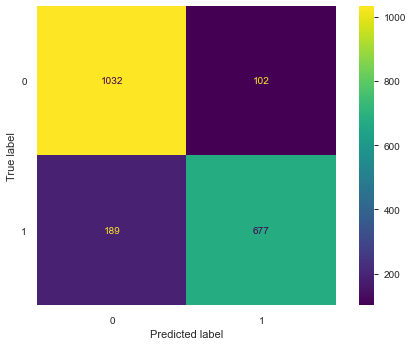

In [48]:
plot_confusion_matrix(final_tree, X_test, Y_test)  
plt.show()  

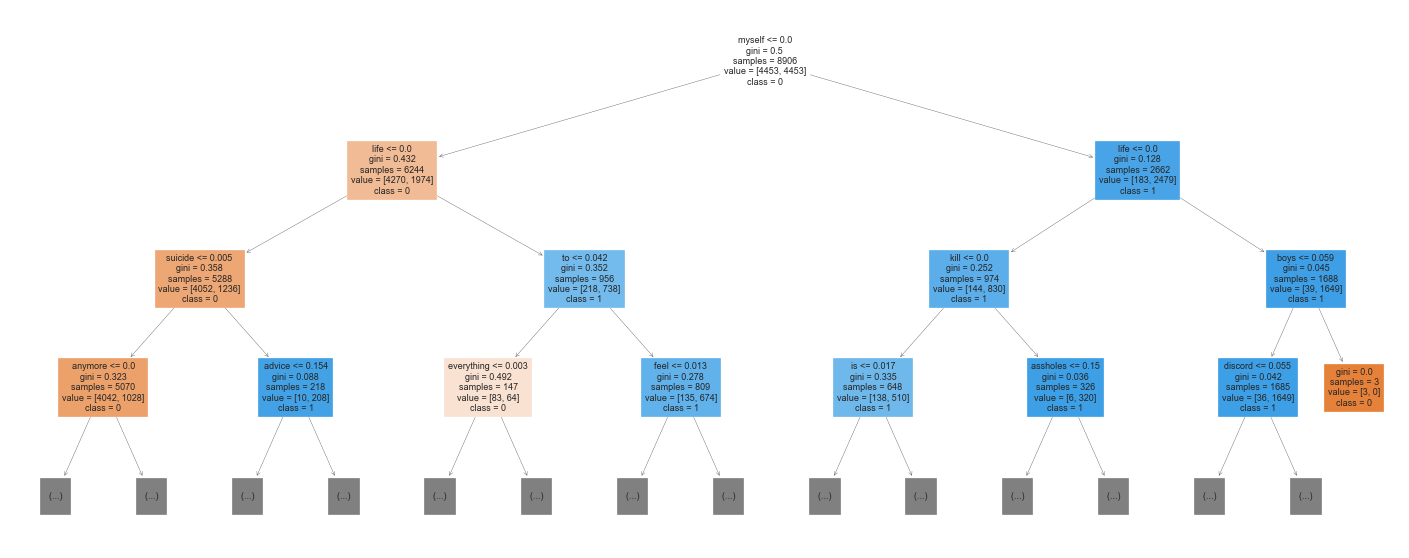

In [49]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(final_tree, max_depth=3, feature_names=df3.columns, class_names=["0", "1"], filled=True, fontsize=9)

In [50]:
y_pred_test = final_tree.predict(X_test)

In [51]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1134
           1       0.87      0.78      0.82       866

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [54]:
#importancia de las palabras
importancia= final_tree.feature_importances_

importancia_atributo = pd.DataFrame(data={"Palabra": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo.head(20)

,Palabra,Importancia
0,myself,0.521821
1,life,0.180421
2,suicide,0.087197
3,anymore,0.050894
4,suicidal,0.038125
5,die,0.031648
6,to,0.015925
7,feel,0.006863
8,is,0.006193
9,kill,0.006067


In [38]:
# IMPLEMENTACION ALGORITMO KNN Nicolas Rodriguez
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3) 
neigh = neigh.fit(X_train, Y_train) 
y_pred = neigh.predict(X_test) 
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.79
Recall: 0.953810623556582
Precisión: 0.6889074228523769
Puntuación F1: 0.8


In [39]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79      1134
           1       0.69      0.95      0.80       866

    accuracy                           0.79      2000
   macro avg       0.82      0.81      0.79      2000
weighted avg       0.84      0.79      0.79      2000

